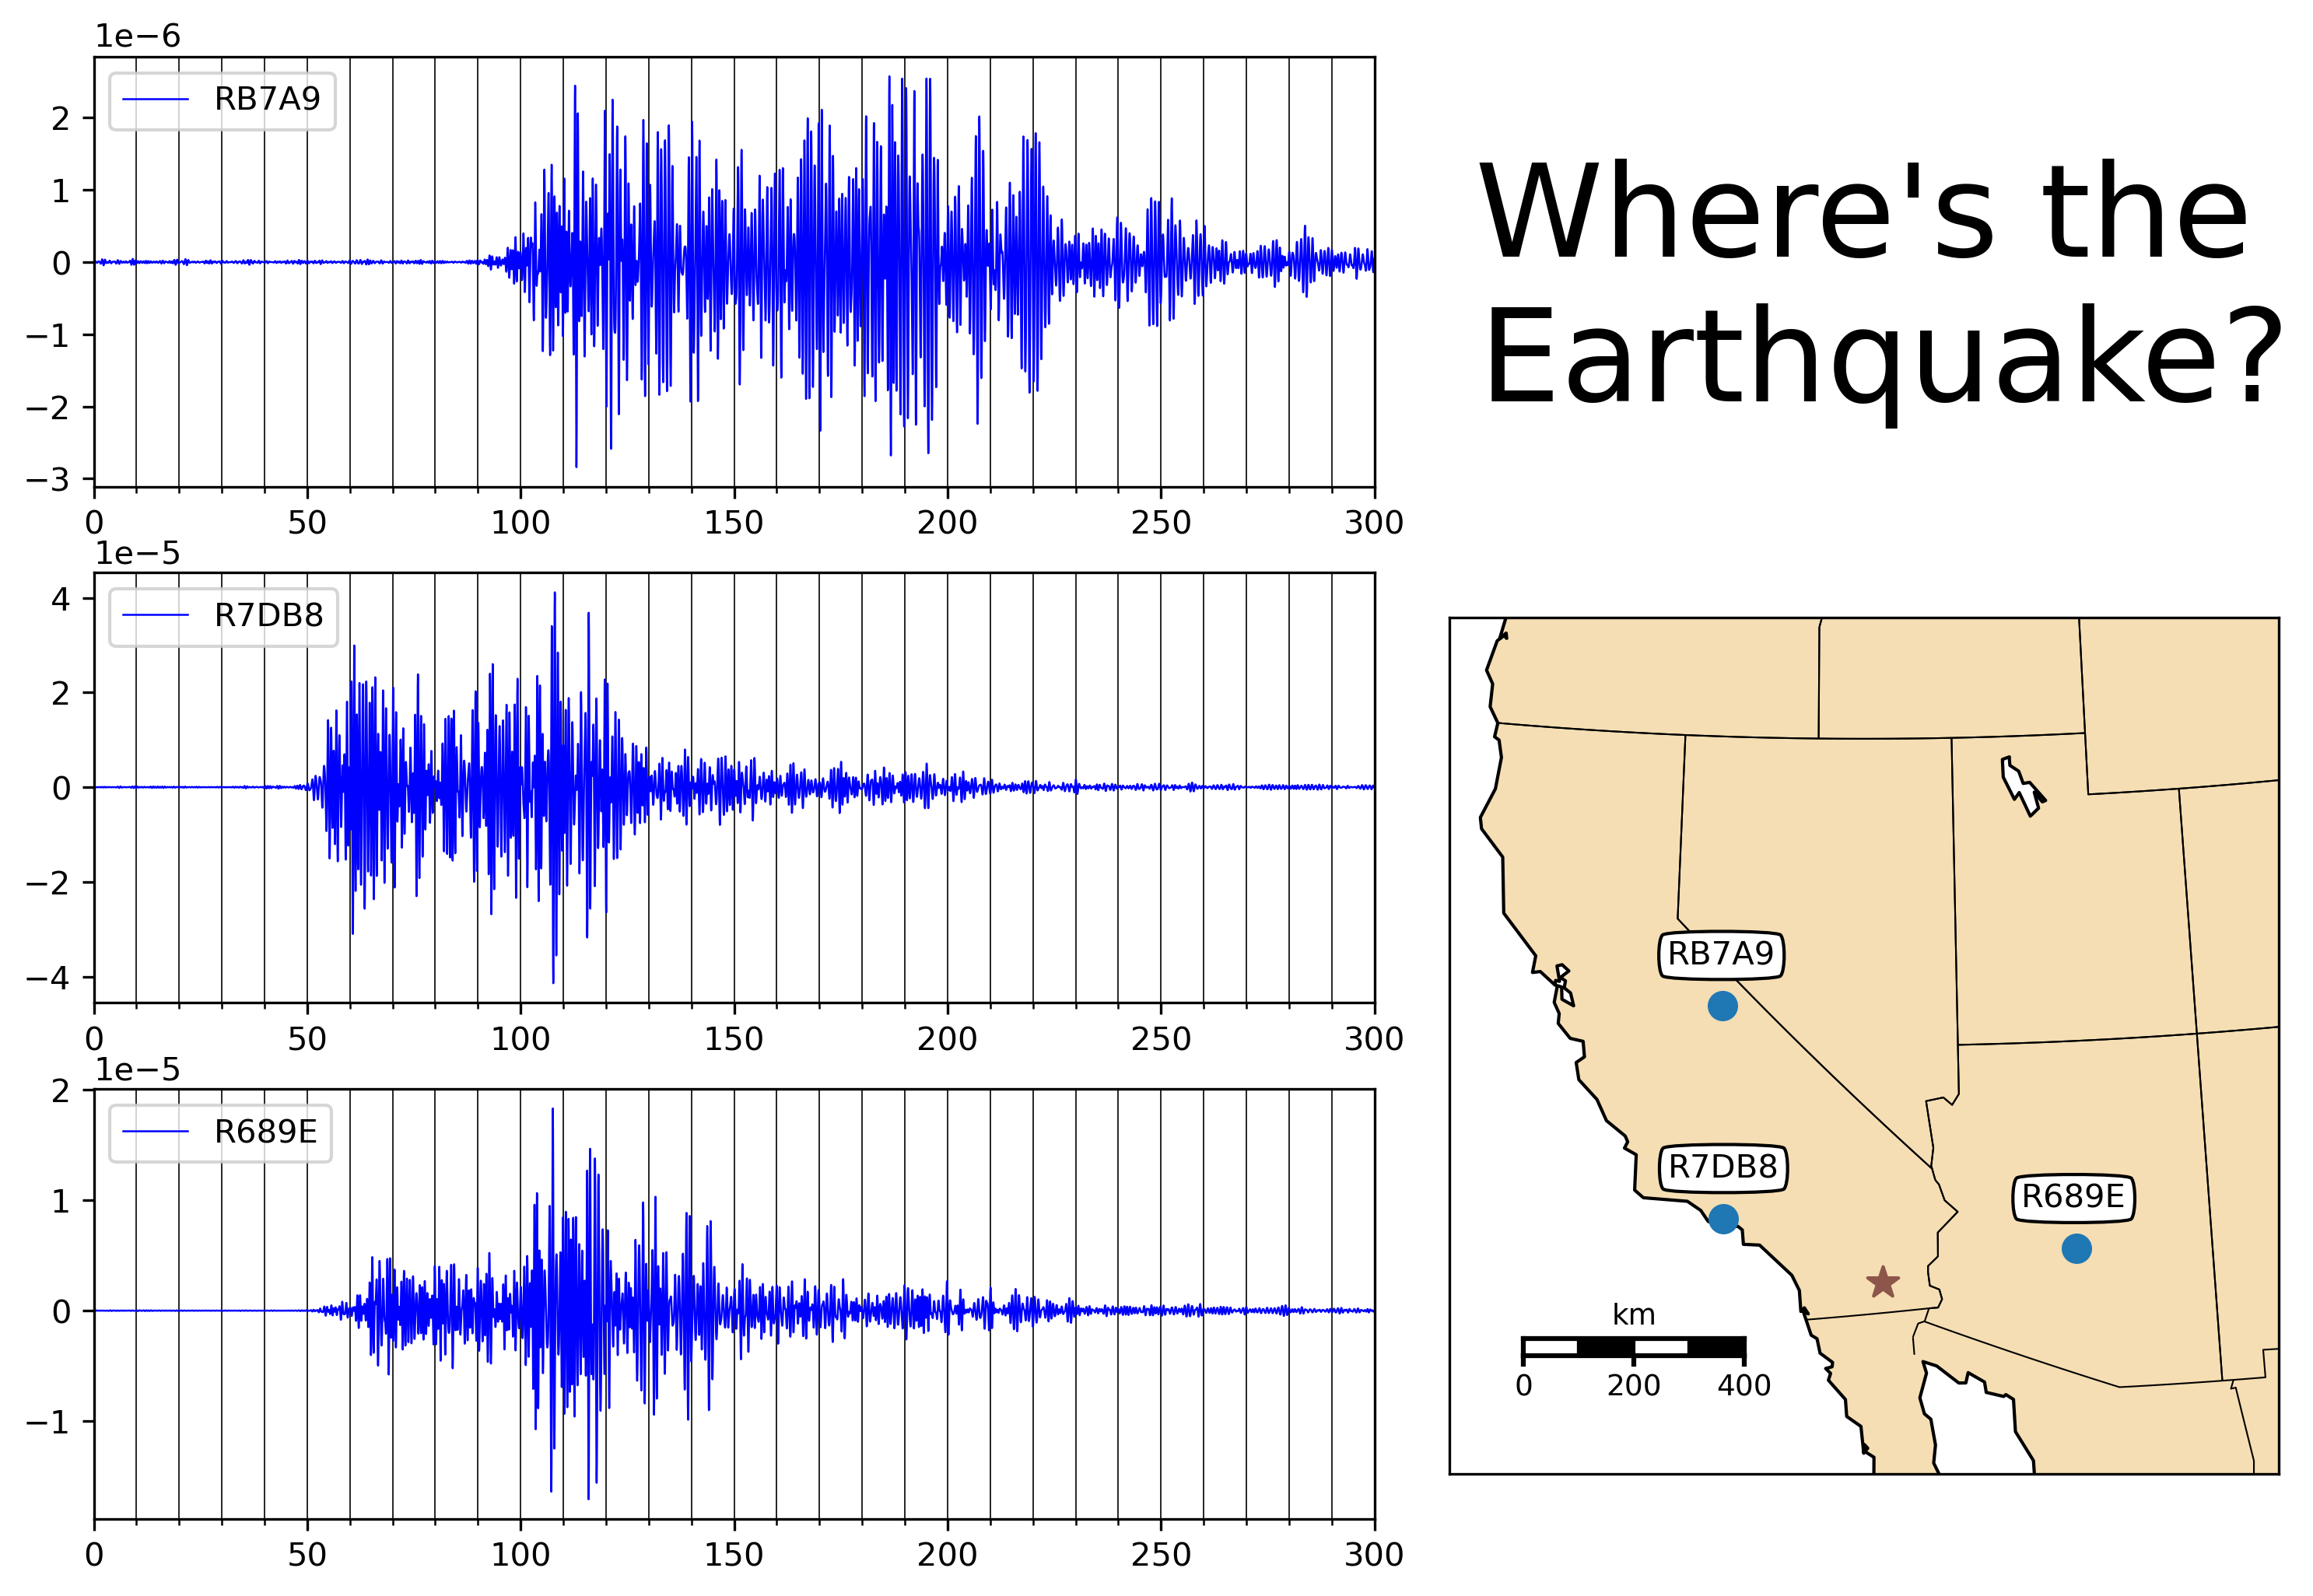

In [2]:
from obspy import UTCDateTime, read_inventory
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.basemap import Basemap
import numpy as np

## Earthquake event information ##

ev_time="2021-06-05 17:55:58"
ev_mag = 5.3
ev_lat = 33.140
ev_lon = -115.635

## Station Information ##
CLIENT = "RASPISHAKE"
STATION = ["RB7A9","R7DB8","R689E"]
count = len(STATION)
NETWORK= ['AM'] * count
LOC_CODE = ["00"] * count
CHANNEL = ['EHZ,'] * count

client = Client(CLIENT)

## Plotting properties ##

lon = []
lat = []

    # Setting up the figure size for A4 
    # https://matplotlib.org/stable/tutorials/intermediate/arranging_axes.html
#fig = plt.figure(figsize=(11.7,8.3))
fig = plt.figure(figsize=(11.7,8.3), dpi=300)
    # SPlitting the page into grids to help with plotting
spec = fig.add_gridspec(nrows=count, ncols=5, left= 0.1)

## Processing properties ##
    # Pre filtering to stabilise the waveform during deconvolution
pre_filt=(0.05, 0.1, 45.0, 50.0)
    #Converts time to UTC date time format for processing
ev_start = UTCDateTime(ev_time)
trim_value = 5
trim_start = ev_start - trim_value
trim_end = ev_start + 5*60 + trim_value

## Waveform gathering and plotting ##

for i in range(count):

    st = client.get_waveforms(NETWORK[i], STATION[i], LOC_CODE[i], CHANNEL[i], trim_start, trim_end, attach_response=True)
    inv= client.get_stations(network=NETWORK[i], sta=STATION[i],loc=LOC_CODE[i], channel=CHANNEL[i])

    lon.append(inv.networks[0].stations[0].longitude)
    lat.append(inv.networks[0].stations[0].latitude)

    st = st.remove_response(pre_filt=pre_filt, output='VEL')

    st.filter('bandpass', freqmin=1.0, freqmax=2.0, corners=4, zerophase=True)
    st.trim(starttime=trim_start + trim_value, endtime=trim_end - trim_value)
    st = st[0]

    ## Waveform plotting ##
    ax = fig.add_subplot(spec[i,0:3])
    # Sets the waveform to the grid row i , and the first column to the third

    ax.plot(st.times("relative"), st.data, color="blue", linewidth=0.6, label=STATION[i])
    # Plots the relative time from the start time (x value), with the waveform info (y axis)
    # in color (American spelling) black ("k") 
    ax.legend(loc="upper left")
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    # Sets minor ticks between major ticks, splitting it to 5, in this case 20s

    ax.tick_params(which="minor")
    ax.xaxis.grid(which="both", color="k",linewidth=0.4)
    ax.set_axisbelow(True)
    plt.xlim(0,300)

ax.tick_params(which="minor")
ax.xaxis.grid(which="both", color="k",linewidth=0.4)
ax.set_axisbelow(True)

## Basemap location ##
axm= fig.add_subplot(spec[-2:,3:])

m = Basemap(width=1500000,height=1550000, resolution='l',projection='eqdc',
            lat_1=25.,lat_2=50,lon_0=-116,lat_0=37)
m.drawcoastlines()
m.fillcontinents(color="wheat")
m.drawcountries()
m.drawstates()

x, y = m(lon,lat)
m.scatter(x,y, 70, marker="o", zorder=4)

bbox_props = dict(boxstyle="Round4,pad=0.3", fc="white")
for i in range(count):
    axm.text(x[i]-1e5,y[i]+7.5e4,STATION[i],zorder=5, bbox=bbox_props)
m.drawmapscale(-120.5,32,-119,32,400,barstyle="fancy")



## Earthquake Plot ##

xe, ye = m(ev_lon, ev_lat)
m.scatter(xe,ye,100,marker="*", zorder=6)

## Title ##

axt = fig.add_subplot(spec[0,3:4])

axt.text(1.1,0.2,"Where's the\n Earthquake?",fontsize=40, ha="center")
axt.axis("off")


plt.show()
fig.savefig("Teacher_Copy.png", dpi="figure",bbox_inches="tight", facecolor="white")